# Part -1

# Accuracy And Explainability Of Auto-ML / DL Over Time-Series Data Implemented On A Weather Data Set

https://www.kaggle.com/datasets/mnassrib/jena-weather-dataset?resource=download&select=jena_weather_2004_2020.csv


Libraries used:

**1. Prophet : prophet 1.1.3 - !pip install prophet - (https://pypi.org/project/prophet/)**

**2. DarTS: darts 0.24.0 - !pip install darts - (https://pypi.org/project/darts/)**

**3. AutoTS : autots 0.5.6 - !pip install autots - (https://pypi.org/project/autots/)**

#### Current Working Directory

In [1]:
import os
from IPython.core.display import HTML
def create_link(path):
    path = os.path.abspath(path)
    url = path if os.path.isdir(path) else os.path.dirname(path)
    return f'<a href="" target="_blank">{path}</a>'
HTML(create_link(os.getcwd()))

In [2]:
# Execue to open the Working Directory
import os
os.system('explorer.exe .')

1

**Importing the required libraries**

In [3]:
import pandas as pd
import pandas_profiling as pp
from typing import Optional
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from darts import TimeSeries
from autots import AutoTS
from prophet import Prophet
import dataframe_image as dfi
import matplotlib.dates as mdates

import warnings
warnings.filterwarnings("ignore")

C:\Users\614074329\Anaconda3\envs\Thesis\lib\site-packages\numba\core\decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.

  warnings.warn(msg, NumbaDeprecationWarning)

C:\Users\614074329\Anaconda3\envs\Thesis\lib\site-packages\visions\backends\shared\nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.

  def hasna(x: np.ndarray) -> bool:


## Some Helper Functions 

In [4]:
def show_df(df):
    """
    Display a DataFrame in a Jupyter notebook or print it otherwise. This function takes a DataFrame `df` as input and displays it using the `display()` function if the current environment is a Jupyter notebook, or prints it using the `print()` function otherwise.
    Parameters
    ----------
    df : (DataFrame) :  The input DataFrame to display or print.
    
    Returns : None

    Examples
    --------
    >>> data = pd.DataFrame({'A': [1, 2, 3], 'B': [4, 5, 6]})
    >>> show_df(data)
       A  B
    0  1  4
    1  2  5
    2  3  6
    """
    pd.set_option("display.max_columns",50)
    try:
        ipy = get_ipython()
        if 'IPKernelApp' not in ipy.config:
            raise ImportError("Not in IPython")
    except:
        # Not in a Jupyter notebook
        print(df)
    else:
        # In a Jupyter notebook
        from IPython.display import display
        display(df)

In [5]:
def df_to_csv(df, col_name, file_name):
    """
    This function takes a pandas DataFrame and a column name as inputs and returns a CSV file with the index column renamed.

    Parameters:
    df (pandas.DataFrame): The DataFrame to be exported.
    col_name (str): The new name for the index column.

    Returns:
    None
    """
    df.reset_index(inplace=True)
    df = df.rename(columns={'index': col_name})
    file_name = "".join([file_name, ".csv"]) if ".csv" not in file_name else file_name
    df.to_csv(file_name, index=False)
    print(file_name, "exported successfully")

In [6]:
def check_empty_values(df):
    """
    Check for empty values in a DataFrame. This function takes a DataFrame `df` as input, iterates over each column of the DataFrame, and creates a result DataFrame that shows the number and percentage of null values, NaN values, and 0 values for each column of the input DataFrame. The function also checks how many rows are completely empty and prints the count. The function does not return anything; it just prints the result DataFrame and the count of empty rows.
    Parameters
    ----------
    df : (DataFrame) : The input DataFrame to check for empty values.

    Returns :  None

    Examples
    --------
    >>> data = pd.DataFrame({'A': [1, np.nan, 3, np.nan], 'B': [4, np.nan, 6, 0]})
    >>> check_empty_values(data)
       nulls zeros nulls_pct zeros_pct
    A      2    0     50.0     50.0
    B      1    1     1        25.0
    Number of completely empty rows: 0
    """
    
    # Create a result DataFrame to store the counts
    result_df = pd.DataFrame(columns=['nulls', 'nulls_%', 'zeros', 'zeros_%'], index=df.columns)
    
    # Iterate over each column of the input DataFrame
    for col in df.columns:
        # Count the number of null values / NaN values in the column
        # isnull() is just an alias for the isna() method
        # Both lines of code are doing the same thing
        # Counting the number of missing or null values in the specified column of the DataFrame
        nulls = df[col].isnull().sum()
        # nans = df[col].isna().sum() 
        
        # Count the number of 0 values in the column
        zeros = (df[col] == 0).sum()
        
        # Compute the percentage of null values in the column
        nulls_pct = (nulls / len(df)) * 100
        
        # Compute the percentage of 0 values in the column
        zeros_pct = (zeros / len(df)) * 100
        
        # Store the counts and percentages in the result DataFrame
        result_df.loc[col] = [nulls, nulls_pct, zeros, zeros_pct]
    
    # Find the number of completely empty rows
    empty_rows = df.isnull().all(axis=1).sum()
    
    # Print the count of empty rows
    print(f'Number of completely empty rows: {empty_rows}')
    
    # Print the result DataFrame
    print(f'Other counts for Nulls, NaNs and Zeroes are:\n')
    show_df(result_df) 

In [7]:
def sub_df(df,col_names):
    """
    Returns a subset of the input dataframe with only the specified columns.

    Parameters:
    -----------
    df : pandas.DataFrame
        The input dataframe.
    col_names : list of str
        The list of column names to be included in the output dataframe.

    Returns:
    --------
    pandas.DataFrame
        A subset of the input dataframe with only the specified columns.
    """
    filtered_df = df[col_names]
    return filtered_df

**Load the data file into a pandas dataframe and check the basic information, such as shape, columns, data types, missing values, etc.**

In [28]:
jena_df = pd.read_csv("jena_weather_2004_2020.csv")
show_df(jena_df.head(5))

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg),rain (mm),raining (s),SWDR (W/m²),PAR (µmol/m²/s),max. PAR (µmol/m²/s),Tlog (degC),CO2 (ppm)
0,2004-01-01 00:10:00,996.82,-0.84,272.57,-1.23,97.2,5.74,5.58,0.16,3.49,5.60,1272.50,2.53,3.63,26.15,0.0,0.0,0.0,0.0,0.0,8.57,NaN
1,2004-01-01 00:20:00,996.69,-0.78,272.64,-1.22,96.8,5.77,5.59,0.18,3.49,5.60,1272.04,2.08,3.25,29.38,0.0,0.0,0.0,0.0,0.0,9.07,NaN
2,2004-01-01 00:30:00,996.69,-0.77,272.64,-1.29,96.3,5.77,5.56,0.21,3.48,5.58,1272.04,2.09,3.75,19.44,0.0,0.0,0.0,0.0,0.0,9.27,NaN
3,2004-01-01 00:40:00,996.67,-0.77,272.65,-1.39,95.6,5.77,5.52,0.25,3.45,5.54,1272.04,1.94,3.63,19.66,0.0,0.0,0.0,0.0,0.0,8.94,NaN
4,2004-01-01 00:50:00,996.52,-0.77,272.66,-1.44,95.2,5.77,5.49,0.28,3.44,5.51,1271.86,1.28,2.25,21.53,0.0,0.0,0.0,0.0,0.0,8.46,NaN


## Exploratory Data Analysis and Clean-Up

1. Check the summary statistics of the numerical columns, such as mean, median, standard deviation, min, max, quartiles, etc. Look for any outliers or anomalies in the data distribution.
2. Check the correlation matrix of the numerical columns to see how they are related to each other. Use a heatmap to visualize the correlation coefficients.
3. Plot the histograms of the numerical columns to see their frequency distribution. Look for any skewness or multimodality in the data.
4. Plot the boxplots of the numerical columns to see their range and outliers. Look for any extreme values or asymmetry in the data.
5. Plot the line plots of the numerical columns over time to see their trend and seasonality. Look for any patterns or cycles in the data.
6. Plot the scatter plots of the numerical columns against each other to see their relationship and possible clusters. Look for any linear or nonlinear patterns or outliers in the data.

In [9]:
print("Shape of the Dataframe (rows, columns) = ", jena_df.shape, "\n")
show_df(jena_df.info())

Shape of the Dataframe (rows, columns) =  (893974, 22) 



<class 'pandas.core.frame.DataFrame'>

RangeIndex: 893974 entries, 0 to 893973

Data columns (total 22 columns):

 #   Column                Non-Null Count   Dtype  

---  ------                --------------   -----  

 0   Date Time             893974 non-null  object 

 1   p (mbar)              893974 non-null  float64

 2   T (degC)              893974 non-null  float64

 3   Tpot (K)              893974 non-null  float64

 4   Tdew (degC)           893974 non-null  float64

 5   rh (%)                893974 non-null  float64

 6   VPmax (mbar)          893974 non-null  float64

 7   VPact (mbar)          893974 non-null  float64

 8   VPdef (mbar)          893974 non-null  float64

 9   sh (g/kg)             893974 non-null  float64

 10  H2OC (mmol/mol)       893974 non-null  float64

 11  rho (g/m**3)          893974 non-null  float64

 12  wv (m/s)              893974 non-null  float64

 13  max. wv (m/s)         89397

None

The Shape of the Dataframe `(rows, columns)` = `(893974, 22)` and all of the columns are float values except the `Date Time` column which is a `datetime64[ns]` object 

In [20]:
show_df(jena_df.describe().transpose())

,count,mean,std,min,25%,50%,75%,max
p (mbar),893974.0,982.737778,272.114169,-9999.00,984.36,989.78,995.17,1020.07
T (degC),893974.0,3.540072,247.863488,-9999.00,3.50,9.53,15.59,37.28
Tpot (K),893974.0,277.394469,254.645561,-9999.00,277.54,283.59,289.66,311.34
Tdew (degC),893974.0,-1.141165,247.695958,-9999.00,0.31,5.21,10.02,23.11
rh (%),893974.0,69.014119,249.912318,-9999.00,64.07,78.40,88.80,100.00
VPmax (mbar),893974.0,7.585617,247.947105,-9999.00,7.85,11.91,17.74,63.77
VPact (mbar),893974.0,3.376664,247.755569,-9999.00,6.25,8.86,12.31,28.32
VPdef (mbar),893974.0,-1.920445,247.642091,-9999.00,0.95,2.28,5.50,47.81
sh (g/kg),893974.0,-0.125501,247.648757,-9999.00,3.94,5.59,7.78,18.13
H2OC (mmol/mol),893974.0,3.481516,247.759020,-9999.00,6.32,8.95,12.45,28.82


## Data Understanding

Let's look at the Data Definitions of the fields that we have in the Data 
- `Date Time`: The date and time of the measurement (YYYY-MM-DD HH:MM:SS).
- `p`: The atmospheric pressure (mbar).
- `T`: The air temperature (°C).
- `Tpot`: The potential temperature (K).
- `Tdew`: The dew point temperature (°C).
- `rh`: The relative humidity (%).
- `VPmax`: The maximum vapor pressure (mbar).
- `VPact`: The actual vapor pressure (mbar).
- `VPdef`: The deficit vapor pressure (mbar).
- `sh`: The specific humidity (g/kg).
- `H2OC`: The water vapor mixing ratio (mmol/mol).
- `rho`: The air density (g/m³).
- `wv`: The wind speed (m/s).
- `max. wv`: The maximum wind speed (m/s).
- `wd`: The wind direction (°).
- `rain`: The total rainfall (mm).
- `raining`: The duration of rainfall (s).
- `SWDR`: The shortwave downwelling radiation (W/m²).
- `PAR`: The photosynthetically active radiation (µmol/m²/s).
- `max.PAR`: The maximum photosynthetically active radiation (µmol/m²/s).
- `Tlog`: The logarithm of the air temperature (°C).
- `CO2`: The carbon dioxide concentration (ppm).

Drawing insights from Domain Knowledge

- `T (degC) and Tpot (K)` : `T (degC)` and `Tpot (K)` are both measures of temperature, but they are expressed in different units. `T (degC)` is the temperature in degrees Celsius, and `Tpot (K)` is the temperature in Kelvin. In general, Tpot is a more accurate measure of temperature than `T (degC)`. This is because `Tpot` takes into account the effects of pressure on temperature.

- `rh and VPdef`: The relative humidity and the deficit vapor pressure are both measures of the amount of water vapor in the air. However, rh is a percentage, while VPdef is a measure of the difference between the maximum vapor pressure and the actual vapor pressure.

- `wv and max.wv`: The wind speed and the maximum wind speed are both measures of the speed of the wind. However, max. wv is the maximum wind speed recorded during a given time period, while wv is the current wind speed.

- `rain and raining`: The total rainfall and the duration of rainfall are both measures of the amount of rain that has fallen. However, rain is the total amount of rain that has fallen, while raining is the amount of time that it has been raining.

- `SWDR and PAR`: The shortwave downwelling radiation and the photosynthetically active radiation are both measures of the amount of radiation that is reaching the Earth's surface. However, SWDR is a measure of all of the shortwave radiation, while PAR is a measure of the radiation that is in the photosynthetically active wavelength range.

These are just a few of the fields in the weather dataset that could be strongly correlated. It is important to note that correlation does not necessarily mean causation. Just because two variables are correlated does not mean that one causes the other. However, correlation can be a useful tool for identifying relationships between variables.

In addition to the fields that are strongly correlated, there are also some fields that indicate the same value in a different metric or a different scale.

- For example, `T and Tlog` both measure the temperature of the air, but they are measured in different ways. T is measured in degrees Celsius, while Tlog is measured in the logarithm of degrees Celsius.

- Another example is `VPmax and VPact`. Both of these fields measure the amount of water vapor in the air, but they are measured in different ways. VPmax is the maximum vapor pressure, while VPact is the actual vapor pressure.

Using the Domain understanding, we will be dropping certain columns. 

- Among `T (degC)`, `Tpot (K)`, `Tdew (degC)`, `Tlog (degC)`,we will keep `Tpot (K)` and drop the remaining.
- Since `Tpot (K)` also accounts for the effect of pressure, we will be dropping `p (mbar)` too.
- Among `rh (%)`, `VPmax (mbar)`, `VPact (mbar)`, `VPdef (mbar)`, we will keep `rh (%)` ad drop the remaining.
- The fields `rain` and `raining` indicat the amount of rainfall and the duration of rainfall. While Rain can be sonsidered to play a role in the overall temperature, it initself is a result of other atmospheric conditions such as Pressure and Humidity etc. It is also not clear how to perceive the `rain` and `rainfall` in terms of these 10 minute intervals. Hence we wil be dropping both of them. 
- Fields like Wind Speed and others are relative. We will be dropping them too. 

cols_to_keep = [`Tpot (K)`,`Date Time`,`rh (%)`,`SWDR (W/m²)`,`PAR (µmol/m²/s)`, `CO2 (ppm)`]

In [10]:
cols_to_keep = ['Date Time','Tpot (K)','rh (%)', 'H2OC (mmol/mol)', 'SWDR (W/m²)','PAR (µmol/m²/s)', 'CO2 (ppm)']

In [11]:
base_df = sub_df(jena_df,cols_to_keep)
show_df(base_df.head())

,Date Time,Tpot (K),rh (%),H2OC (mmol/mol),SWDR (W/m²),PAR (µmol/m²/s),CO2 (ppm)
0,2004-01-01 00:10:00,272.57,97.2,5.60,0.0,0.0,NaN
1,2004-01-01 00:20:00,272.64,96.8,5.60,0.0,0.0,NaN
2,2004-01-01 00:30:00,272.64,96.3,5.58,0.0,0.0,NaN
3,2004-01-01 00:40:00,272.65,95.6,5.54,0.0,0.0,NaN
4,2004-01-01 00:50:00,272.66,95.2,5.51,0.0,0.0,NaN


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


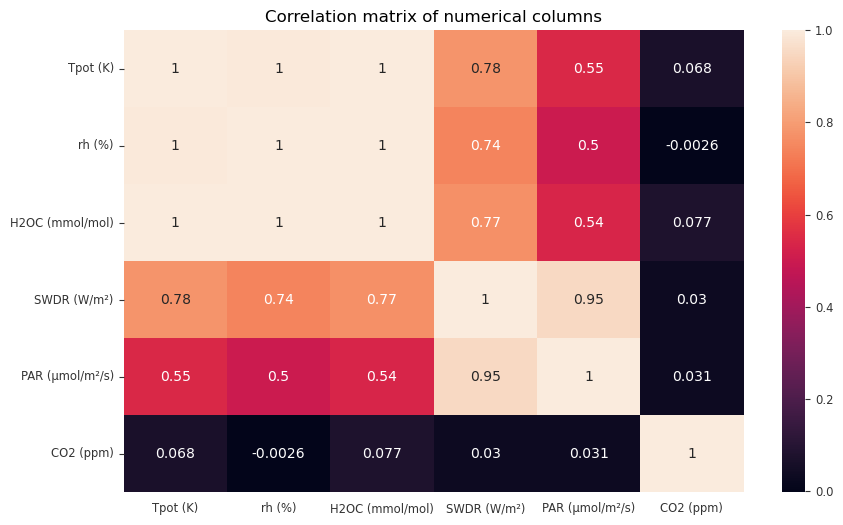

In [13]:
corr = base_df.corr()
plt.figure(figsize=(10,6)) # set the figure size
sns.heatmap(corr, annot=True)
plt.title("Correlation matrix of numerical columns") # add a title
plt.legend(loc="best") # add a legend
plt.savefig("Correlation matrix of numerical columns on filtered DF.png") # save the figure
plt.show()

In [14]:
base_df['Date Time'] = pd.to_datetime(base_df['Date Time'])
print(base_df['Date Time'].dtype)
base_df.sort_values(by='Date Time', inplace=True)
show_df(base_df.head(5))

datetime64[ns]


,Date Time,Tpot (K),rh (%),H2OC (mmol/mol),SWDR (W/m²),PAR (µmol/m²/s),CO2 (ppm)
0,2004-01-01 00:10:00,272.57,97.2,5.60,0.0,0.0,NaN
1,2004-01-01 00:20:00,272.64,96.8,5.60,0.0,0.0,NaN
2,2004-01-01 00:30:00,272.64,96.3,5.58,0.0,0.0,NaN
3,2004-01-01 00:40:00,272.65,95.6,5.54,0.0,0.0,NaN
4,2004-01-01 00:50:00,272.66,95.2,5.51,0.0,0.0,NaN


In [15]:
show_df(base_df.tail())

,Date Time,Tpot (K),rh (%),H2OC (mmol/mol),SWDR (W/m²),PAR (µmol/m²/s),CO2 (ppm)
893969,2020-12-31 23:20:00,277.16,80.0,5.89,0.0,0.0,433.0
893970,2020-12-31 23:30:00,277.01,83.1,6.05,0.0,0.0,439.6
893971,2020-12-31 23:40:00,276.88,82.2,5.93,0.0,0.0,435.2
893972,2020-12-31 23:50:00,276.95,81.4,5.90,0.0,0.0,433.9
893973,2021-01-01 00:00:00,276.89,82.4,5.95,0.0,0.0,436.5


- There is just `1 value` for the date `2021-01-01`. Data aggregation will not be possible and would rather give erroneous values when aggregated, thus dropping the last row of data.

In [16]:
base_df.drop(base_df.tail(1).index,inplace=True)
show_df(base_df.tail())

,Date Time,Tpot (K),rh (%),H2OC (mmol/mol),SWDR (W/m²),PAR (µmol/m²/s),CO2 (ppm)
893968,2020-12-31 23:10:00,277.15,79.04,5.82,0.0,0.0,431.3
893969,2020-12-31 23:20:00,277.16,80.00,5.89,0.0,0.0,433.0
893970,2020-12-31 23:30:00,277.01,83.10,6.05,0.0,0.0,439.6
893971,2020-12-31 23:40:00,276.88,82.20,5.93,0.0,0.0,435.2
893972,2020-12-31 23:50:00,276.95,81.40,5.90,0.0,0.0,433.9


In [17]:
check_empty_values(base_df)

Number of completely empty rows: 0

Other counts for Nulls, NaNs and Zeroes are:




,nulls,nulls_%,zeros,zeros_%
Date Time,0,0.0,0,0.0
Tpot (K),0,0.0,0,0.0
rh (%),0,0.0,0,0.0
H2OC (mmol/mol),0,0.0,0,0.0
SWDR (W/m²),0,0.0,428409,47.921917
PAR (µmol/m²/s),0,0.0,418431,46.805776
CO2 (ppm),210386,23.53382,0,0.0


We see that all of the Columns except `CO2` have no missing values, but some `Zero` values which is expected. Since all of the other columns have data, we will be dropping the `CO2` column as it has `23.53%` data missing.

In [18]:
base_df.drop(columns = ["CO2 (ppm)"], inplace = True)

In [19]:
show_df(base_df.describe().transpose())

,count,mean,std,min,25%,50%,75%,max
Tpot (K),893973.0,277.394470,254.645703,-9999.0,277.54,283.59,289.66,311.34
rh (%),893973.0,69.014104,249.912457,-9999.0,64.07,78.40,88.80,100.00
H2OC (mmol/mol),893973.0,3.481513,247.759159,-9999.0,6.32,8.95,12.45,28.82
SWDR (W/m²),893973.0,117.923164,325.319837,-9999.0,0.00,2.41,166.60,1219.32
PAR (µmol/m²/s),893973.0,237.012482,475.878260,-9999.0,0.00,8.11,331.66,2401.54


**1. The above describe function shows that there are outliers in each of the fields. `-9999.0000` and `-9999.9900` are the outlier which could be a result of sensor errors.**

**2. Let's check for how many rows are affected with this outlier.**

In [32]:
cols = [ each for each in base_df.columns if base_df[each].dtype in ['int64', 'float64']]
result = base_df[(base_df[cols] == base_df[cols].min()).any(axis=1)]
print("No. of rows affected by these outliers in each of the fields:", result.shape[0])
print("% of total rows affected:", round(100*(result.shape[0]/base_df.shape[0]),2))

No. of rows affected by these outliers in each of the fields: 548

% of total rows affected: 0.06


- We see that there are `548` rows affected. (earlier`9272` before dropping `CO2 (ppm)` column)
- However, we are avoiding droping these rows as it might affect the granularity of data and cause gaps in recorded data. Instead, we will replace the sensor errors with `np.nan` and use `ffill` to fix them. 

In [33]:
# create a copy of the DataFrame
df = base_df.copy()
print("Before fix:")
show_df(df.describe().transpose())

# display(df)
for col in cols:
    df[col].replace(df[col].min(), np.nan, inplace = True) # this will replace the min value in each col
    df[col].replace(-9999, np.nan, inplace = True) # After replacing min value, -9999.00 maybe left if min() was -9999.99
    df[col].fillna(method = 'ffill', inplace = True) # using forward fill to replace np.nan

print(" ")
print("After fix:")
show_df(df.describe().transpose())

Before fix:


,count,mean,std,min,25%,50%,75%,max
Tpot (K),893973.0,277.394470,254.645703,-9999.0,277.54,283.59,289.66,311.34
rh (%),893973.0,69.014104,249.912457,-9999.0,64.07,78.40,88.80,100.00
H2OC (mmol/mol),893973.0,3.481513,247.759159,-9999.0,6.32,8.95,12.45,28.82
SWDR (W/m²),893973.0,117.923164,325.319837,-9999.0,0.00,2.41,166.60,1219.32
PAR (µmol/m²/s),893973.0,237.012482,475.878260,-9999.0,0.00,8.11,331.66,2401.54


 

After fix:


,count,mean,std,min,25%,50%,75%,max
Tpot (K),893973.0,283.699750,8.359440,250.60,277.55,283.61,289.66,311.34
rh (%),893973.0,75.170825,16.809323,12.95,64.07,78.40,88.80,100.00
H2OC (mmol/mol),893973.0,9.614879,4.135538,0.80,6.32,8.95,12.45,28.82
SWDR (W/m²),893973.0,124.445321,207.886439,0.00,0.00,2.41,167.40,1219.32
PAR (µmol/m²/s),893973.0,243.913254,403.515818,0.00,0.00,8.30,333.20,2401.54


**Check for any Duplicate Rows of Data in the data set.**

In [34]:
def check_duplicate_rows(df):
    """
    Check for duplicate rows in a DataFrame. This function takes a DataFrame `df` as input and checks for duplicate rows in the DataFrame. It uses the `duplicated()` method with the `keep='first'` argument to find all but the first occurrence of each set of duplicate rows. The function then creates a new DataFrame containing only the duplicate rows and displays its shape and contents.
    Parameters
    ----------
    df : (DataFrame) : The input DataFrame to check for duplicate rows.
    Returns
    -------
    None
    Examples
    --------
    >>> data = pd.DataFrame({'A': [1, 4, 2, 3, 4, 2], 'B': [4, 7, 5, 6, 7, 5]})
    >>> check_duplicate_rows(data)
    (1, 2)
       A  B
    1  4  7
    4  2  5
    """
    # Find the duplicate rows using keep='fist' so that one value is considered unique and others are counted as actual duplicates.
    duplicates = df.duplicated(keep='first')

    # Create a new DataFrame with the duplicate rows
    duplicate_rows = df[duplicates]

    # Display the duplicate rows
    print(duplicate_rows.shape)
    show_df(duplicate_rows)    

In [35]:
check_duplicate_rows(df)

(328, 6)


,Date Time,Tpot (K),rh (%),H2OC (mmol/mol),SWDR (W/m²),PAR (µmol/m²/s)
341856,2010-01-07 00:10:00,291.69,78.40,16.20,0.00,0.00
341857,2010-01-07 00:20:00,291.65,78.50,16.17,0.00,0.00
341858,2010-01-07 00:30:00,291.75,78.30,16.23,0.00,0.00
341859,2010-01-07 00:40:00,291.65,78.40,16.15,0.00,0.00
341860,2010-01-07 00:50:00,291.38,79.50,16.10,0.00,0.00
...,...,...,...,...,...,...
537834,2014-03-21 16:50:00,293.10,40.48,8.70,47.08,97.88
537652,2014-03-21 17:00:00,292.93,41.22,8.77,60.97,119.30
537836,2014-03-21 17:10:00,292.77,41.85,8.82,72.03,138.22
537654,2014-03-21 17:20:00,292.57,42.36,8.82,55.94,110.42


- Using `keep='first'` on the `df.duplicated(keep='first')` function, the first value is considered unique and others are counted as actual duplicates. We see that there are `328 rows` of duplicates in the dataset.
- We will now be droping the duplicates using `df.drop_duplicates(keep='first')`

In [36]:
# Remove all but the first occurrence of each set of duplicate rows
df = df.drop_duplicates(keep='first')
check_duplicate_rows(df)

(0, 6)


,Date Time,Tpot (K),rh (%),H2OC (mmol/mol),SWDR (W/m²),PAR (µmol/m²/s)


After droping the duplicates, we now see that the `check_duplicate_rows(df)` function returns `0` rows, meaning all duplicate rows are now sccessfully dropped.

**Check for any missing Data in the data set.**

In [37]:
def find_gaps(df, freq):
    """
    Find gaps in a time series DataFrame.
    This function takes a DataFrame `df` with a DatetimeIndex and a frequency `freq` as input and returns a
    list of the missing timestamps.
    
    Parameters
    ----------
    df : (DataFrame) : The input DataFrame with a DatetimeIndex.
    freq : (str) :  The expected frequency of the data as a string that can be parsed by `pd.date_range`.
    
    Returns
    -------
    df : (DataFrame) :  A DataFrame with single column of the missing timestamps.
    
    Examples
    --------
    >>> data = pd.read_csv('mydata.csv', index_col='datetime', parse_dates=True)
    >>> result = find_gaps(data, '10T')
    >>> print(result)
    
    |     | mising_timestamps   |
    |-----|---------------------|
    |   0 | 2009-08-10 09:50:00 | 
    |   1 | 2009-08-10 10:00:00 | 
    |   2 | 2013-05-16 09:00:00 | 
    |   3 | 2014-07-30 08:10:00 | 
    |   4 | 2014-09-24 17:10:00 | 
    | ... | ...                 | 
    | 591 | 2020-05-29 10:20:00 | 
    | 592 | 2020-05-29 10:30:00 | 
    | 593 | 2020-05-29 10:40:00 | 
    | 594 | 2020-05-29 10:50:00 | 
    | 595 | 2020-05-29 11:00:00 | 
    """
    
    # Create a date range with the expected frequency
    expected_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq=freq)
    
    # Find the missing timestamps
    missing_timestamps = expected_index.difference(df.index)
    
    if len(missing_timestamps) == 0:
        response_df = pd.DataFrame()
        return response_df
    else:
        # Convert the missing timestamps to a list and return it
        response_df = pd.DataFrame(missing_timestamps.tolist())
        response_df.columns = ["mising_timestamps"]
        return response_df

In [38]:
# Setting the Date Time field as the index, for further processing. 
df = df.set_index("Date Time")
df = df.sort_index()

In [39]:
# Check for gaps in the data
missing_data = find_gaps(df, '10T')

# Print the result
print("No of Timestamps missing between {} and {} : {}".format(df.index.min(), df.index.max(),len(missing_data)))
show_df(missing_data.head())

No of Timestamps missing between 2004-01-01 00:10:00 and 2020-12-31 23:50:00 : 596


,mising_timestamps
0,2009-08-10 09:50:00
1,2009-08-10 10:00:00
2,2013-05-16 09:00:00
3,2014-07-30 08:10:00
4,2014-09-24 17:10:00


We see that there are `596 rows / timestamps` that are misisng in the supplied data. We need to fix the missing values. 

### Imputing missing data

We can chose to perform data imputation in various ways. The most common ones are: 
1. Mean Imputation
2. Linear Interpolation
3. Seasonal + Linear Interpolation

In this case, we will go with #2 Linear, and try to interpolate data. 

In [40]:
    def sub_df(df,col_names):
        """
        Returns a subset of the input dataframe with only the specified columns.

        Parameters:
        -----------
        df : pandas.DataFrame
            The input dataframe.
        col_names : list of str
            The list of column names to be included in the output dataframe.

        Returns:
        --------
        pandas.DataFrame
            A subset of the input dataframe with only the specified columns.
        """
        filtered_df = df[col_names]
        return filtered_df

Creating an `expected_index` date range to pass to the imputation function for it to fill the gaps, where the existing DF might be having gaps

In [41]:
expected_index = pd.date_range(start=df.index.min(), end=df.index.max(),
                               freq='10T')
df = df.reindex(expected_index)
df.head()

,Tpot (K),rh (%),H2OC (mmol/mol),SWDR (W/m²),PAR (µmol/m²/s)
2004-01-01 00:10:00,272.57,97.2,5.60,0.0,0.0
2004-01-01 00:20:00,272.64,96.8,5.60,0.0,0.0
2004-01-01 00:30:00,272.64,96.3,5.58,0.0,0.0
2004-01-01 00:40:00,272.65,95.6,5.54,0.0,0.0
2004-01-01 00:50:00,272.66,95.2,5.51,0.0,0.0


In [42]:
imputed_df = pd.DataFrame()
for col in df.columns:
    if df[col].dtype in ['int64', 'float64']:
        temp = sub_df(df, [col])
        # Interpolate missing values using linear interpolation 
        imputed_df[col] = temp[col].interpolate(method='linear')

In [43]:
# Check for gaps after imputation to confirm the data
missing_data2 = find_gaps(imputed_df, '10T')

# Print the result
print("No of Timestamps missing between {} and {} : {}".format(imputed_df.index.min(),
                                                               imputed_df.index.max(),
                                                               len(missing_data2)))
show_df(missing_data2.head())

No of Timestamps missing between 2004-01-01 00:10:00 and 2020-12-31 23:50:00 : 0


""


In [44]:
show_df(imputed_df.head())

,Tpot (K),rh (%),H2OC (mmol/mol),SWDR (W/m²),PAR (µmol/m²/s)
2004-01-01 00:10:00,272.57,97.2,5.60,0.0,0.0
2004-01-01 00:20:00,272.64,96.8,5.60,0.0,0.0
2004-01-01 00:30:00,272.64,96.3,5.58,0.0,0.0
2004-01-01 00:40:00,272.65,95.6,5.54,0.0,0.0
2004-01-01 00:50:00,272.66,95.2,5.51,0.0,0.0


## EDA Plots

**Resetting the index of `imputed_df` to be used for EDA**

In [45]:
# imputed_df.reset_index(inplace = True)
# imputed_df.rename(columns = {"index":"Date Time"}, inplace = True)
# show_df(imputed_df.head())

In [46]:
def aggregate_df(df: pd.DataFrame, freq: str, datetime_col: Optional[str] = None) -> pd.DataFrame:
    """
    Aggregates a DataFrame by a given frequency.

    :param df: Input DataFrame
    :type df: pd.DataFrame
    :param freq: Aggregation frequency. Can be either 'hour'[H] or 'day' [D]
    :type freq: str
    :param datetime_col: Name of the datetime column, defaults to None
    :type datetime_col: Optional[str], optional
    :return: Aggregated DataFrame
    :rtype: pd.DataFrame
    """
    # Check if the DataFrame already has a datetime index
    if not isinstance(df.index, pd.DatetimeIndex):
        # If not, find the datetime column by itself if not provided
        if datetime_col is None:
            for col in df.columns:
                if pd.api.types.is_datetime64_any_dtype(df[col]):
                    datetime_col = col
                    break

        # Raise an error if no datetime column is found
        if datetime_col is None:
            raise ValueError("No datetime column found in the DataFrame")

        # Convert the datetime column to a datetime object and set it as the index of the DataFrame
        df[datetime_col] = pd.to_datetime(df[datetime_col])
        df.set_index(datetime_col, inplace=True)

    # Perform the aggregation as per requested frequency and return the aggregated DataFrame
    
    mean_df = df.resample(freq).agg('mean')
    median_df = df.resample(freq).agg('median')
    mode_df = df.resample(freq).agg(lambda x: x.mode()[0])
    result_df = (mean_df + median_df + mode_df) / 3
    
    return result_df


In [47]:
def aggregate_high_df(df: pd.DataFrame, freq: str, datetime_col: Optional[str] = None) -> pd.DataFrame:
    """
    Aggregates a DataFrame by a given frequency.

    :param df: Input DataFrame
    :type df: pd.DataFrame
    :param freq: Aggregation frequency. Can be either 'week'[W], 'month-START' [MS], 'month-END' [M]
    :type freq: str
    :param datetime_col: Name of the datetime column, defaults to None
    :type datetime_col: Optional[str], optional
    :return: Aggregated DataFrame
    :rtype: pd.DataFrame
    """
    # Check if the DataFrame already has a datetime index
    if not isinstance(df.index, pd.DatetimeIndex):
        # If not, find the datetime column by itself if not provided
        if datetime_col is None:
            for col in df.columns:
                if pd.api.types.is_datetime64_any_dtype(df[col]):
                    datetime_col = col
                    break

        # Raise an error if no datetime column is found
        if datetime_col is None:
            raise ValueError("No datetime column found in the DataFrame")

        # Convert the datetime column to a datetime object and set it as the index of the DataFrame
        df[datetime_col] = pd.to_datetime(df[datetime_col])
        df.set_index(datetime_col, inplace=True)

    # Perform the aggregation as per requested frequency and return the aggregated DataFrame
    
    max_df = df.resample(freq).agg('max')
    
    return max_df


In [48]:
aggregated_df_hour = aggregate_df(imputed_df, "H")
show_df(aggregated_df_hour.head())
print(aggregated_df_hour.shape)

,Tpot (K),rh (%),H2OC (mmol/mol),SWDR (W/m²),PAR (µmol/m²/s)
2004-01-01 00:00:00,272.637333,95.906667,5.582000,0.0,0.0
2004-01-01 01:00:00,272.680000,93.272222,5.407222,0.0,0.0
2004-01-01 02:00:00,272.697778,92.033333,5.335000,0.0,0.0
2004-01-01 03:00:00,272.675000,92.227778,5.330000,0.0,0.0
2004-01-01 04:00:00,272.414444,93.344444,5.276667,0.0,0.0


(149040, 5)


In [49]:
aggregated_df_day= aggregate_df(imputed_df, "D")
show_df(aggregated_df_day.head())
print(aggregated_df_day.shape)

,Tpot (K),rh (%),H2OC (mmol/mol),SWDR (W/m²),PAR (µmol/m²/s)
2004-01-01,272.227086,87.238228,4.329510,8.603240,17.430793
2004-01-02,284.429491,64.079884,8.071736,14.864583,31.186528
2004-01-03,271.176134,83.235833,4.179005,27.235208,54.494653
2004-01-04,285.319861,69.169630,6.789884,69.141736,135.938449
2004-01-05,289.212292,75.936713,12.561736,76.902106,163.125926


(6210, 5)


In [50]:
# Weekly and Monthly aggregation to mae it easier to plot and see trend of Growth / Decline in values

# Aggregating to obtain the Weekly Max values for each week on the DF
aggregated_week_max = aggregate_high_df(imputed_df, "W")
print("aggregated_week_max : ", aggregated_week_max.shape)
show_df(aggregated_week_max.head())
print("*************************************************************************************************************\n")

# Aggregating to obtain the Monthly Max values for each week on the DF
aggregated_month_max = aggregate_high_df(imputed_df, "MS")
print("aggregated_month_max : ",aggregated_month_max.shape)
show_df(aggregated_month_max.head())

aggregated_week_max :  (888, 5)


,Tpot (K),rh (%),H2OC (mmol/mol),SWDR (W/m²),PAR (µmol/m²/s)
2004-01-04,289.22,97.5,8.98,742.66,1471.04
2004-01-11,299.10,99.0,18.91,838.63,1691.12
2004-01-18,285.21,97.7,9.31,280.89,534.56
2004-01-25,278.27,98.6,6.55,401.61,764.09
2004-02-01,283.74,97.3,8.48,449.90,878.96


*************************************************************************************************************



aggregated_month_max :  (204, 5)


,Tpot (K),rh (%),H2OC (mmol/mol),SWDR (W/m²),PAR (µmol/m²/s)
2004-01-01,299.10,99.0,18.91,838.63,1691.12
2004-02-01,299.07,99.6,16.61,942.45,1895.75
2004-03-01,301.00,99.6,17.03,1092.15,2222.01
2004-04-01,302.96,99.4,17.40,1000.00,1967.18
2004-05-01,302.57,99.5,18.46,1037.42,2034.75


### Exporting the Daily and Hourly Aggregated DFs

In [51]:
df_to_csv(df = aggregated_df_day , col_name = "Date Time", file_name = "aggregated_df_day")
df_to_csv(df = aggregated_df_hour , col_name = "Date Time", file_name = "aggregated_df_hour")

aggregated_df_day.csv exported successfully

aggregated_df_hour.csv exported successfully


In [52]:
df_to_csv(df = aggregated_week_max , col_name = "Date Time", file_name = "aggregated_week_max")
df_to_csv(df = aggregated_month_max , col_name = "Date Time", file_name = "aggregated_month_max")

aggregated_week_max.csv exported successfully

aggregated_month_max.csv exported successfully


--************-- END of Part 1 --************--